In [1]:
%run "preamble.ipynb"
%matplotlib inline
import torch
from torch.autograd import Variable
from dl4nlp.util import *
from dl4nlp.words import *
from torch import nn
import torch.nn.functional as F
import numpy as np
from torch.nn import Parameter
from dl4nlp.tikz import *
import IPython.display
IPython.display.display_latex(IPython.display.Latex(filename="tex/macros.tex"))

<IPython.core.display.Javascript object>

<center>
<h1>Deep Learning for Natural Language Processing I</h1>
<h2>Word Vectors</h2>
<br>
Tim Rocktäschel<br>
<a href="https://rockt.github.com">rockt.github.com</a> <a href="mailto:tim.rocktaschel@cs.ox.ac.uk">tim.rocktaschel@cs.ox.ac.uk</a> <a href="https://twitter.com/_rockt">Twitter: @_rockt</a><br>
<img src="./figures/oxford.svg" width=30%><br>
2nd Int'l Summer School on Data Science, Split, Croatia<br>
27th September 2017<br>
</center>

# Short CV

- 2012: Diplom Informatik (M.Sc. CS) from Humboldt University Berlin
- 2012-2013: Research Assistant at Humboldt University Berlin
- 2013-2017: Ph.D. at University College London
  - 2013-2016: Microsoft Research Ph.D. Scholarship 
  - 2017 Google Ph.D. Fellow in Natural Language Processing
- May-Sep 2015: Research Intern at Google DeepMind
- Since May 2017: PostDoc at University of Oxford
  - Mostly working on Reinforcement Learning
- From Oct 2017: Stipendiary Lecturer at Hertford College (University of Oxford)


# Overview
- [DL for NLP I: Word Vectors](words.ipynb)
- [DL for NLP II: Recurrent Neural Networks](sequences.ipynb)
- [DL for NLP III: Attention](attention.ipynb)
- [DL for NLP IV: Memory](memory.ipynb)

# Approach
- I will focus on the basics...
- ...but also scratch recent developments
- I will not cover:
  - Generation (**Nal tomorrow!**)
  - Linguistics
  - Overview of NLP tasks

# Word Representations
- Many NLP tasks require feature representations of input words
- We would like to learn such representations automatically from large text corpora
- Semantically similar words should have similar representation
- Formally, given a word in a vocabulary $w\in\mathbb{V}$, find vector representation $\vec{v}_w\in\R^k$
$$
f_\theta(w) = \vec{v}_w
$$

# Sparse (One-hot) Representation
- We could assign a one-hot vector to every word, thus $f : \N \to \{0,1\}^{|\mathbb{V}|}$
$$
\begin{align}
f(\text{apples}) &= [1\ 0\ \ldots\ 0\ 0]\\
f(\text{oranges}) &= [0\ 1\  \ldots\ 0\ 0]\\
&\ \, \vdots\\
f(\text{dad}) &= [0\ 0\ \ldots\ 1\ 0] \\
f(\text{father}) &= [0\ 0\ \ldots\ 0\ 1]
\end{align}
$$

## Problem
- Words representations do not share any information
$\vec{v}_\text{dad}\neq\vec{v}_\text{father}$
- No notion of similarity:
$\vec{v}_\text{apples}\not\sim\vec{v}_\text{oranges}$

# Count-based Word Representations

> "You shall know a word by the company it keeps." — J.R. Firth (1957)
    
... | -3 | -2 | -1 | 0 | 1 | 2 | 3 | ...
:--:|:--:|:--:
... | skin | of | ripe | **apples** | is | generally | red | ...
... | of | farmers | stored | **apples** | in | frostproof | cellars | ...
... | skin | of | ripe | **oranges** | can | range | from | ...
... | . | A | biological | **father** | is | the | male | ...

In [2]:
contexts = [context.split(" ") for context in [
    "skin of ripe apples is generally red",
    "of farmers stored apples in frostproof cellars",
    "skin of ripe oranges can range from",
    ". A biological father is the male"
]]

f, vocab, id2word = get_counts(contexts)

tmp = r"$$\begin{align}"
for word in ["apples", "oranges", "father"]:
    vec = "[" + "\ ".join(["%1.0f" % x for x in f[word]]) + "]"
    tmp += r"\vec{v}_\text{%s} &= %s\\" % (word, vec)
tmp += r"\end{align}$$"         
IPython.display.display_latex(IPython.display.Latex(tmp))

# Cosine-similarity


$$
\cos(\vec{u}, \vec{v}) = \frac{\vec{u}^\top\vec{v}}{\|\vec{u}\|\|\vec{v}\|}
$$

In [3]:
def cos(u, v):
    return F.cosine_similarity(torch.Tensor(u), torch.Tensor(v), 0)[0]

for u in ["apples", "oranges", "father"]:
    for v in ["apples", "oranges", "father"]:
        print("%-8s %-8s %4.2f" % (u, v, cos(f[u], f[v])))


apples   apples   1.00
apples   oranges  0.52
apples   father   0.13
oranges  apples   0.52
oranges  oranges  1.00
oranges  father   0.00
father   apples   0.13
father   oranges  0.00
father   father   1.00


In [4]:
C = to_df(f, id2word)
C

,skin,of,ripe,apples,is,generally,red,farmers,stored,in,...,oranges,can,range,from,.,A,biological,father,the,male
.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
apples,1.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
biological,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
can,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
cellars,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
farmers,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
father,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
from,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
frostproof,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Matrix Factorization
- Co-occurrence counts $\mat{C}\in\N^{|\mathbb{V}|\times|\mathbb{V}|}$ factorized into two low-dimensional matrices $\mat{U}\in\R^{|V|\times k}$ and $\mat{V}\in\R^{k\times |V|}$

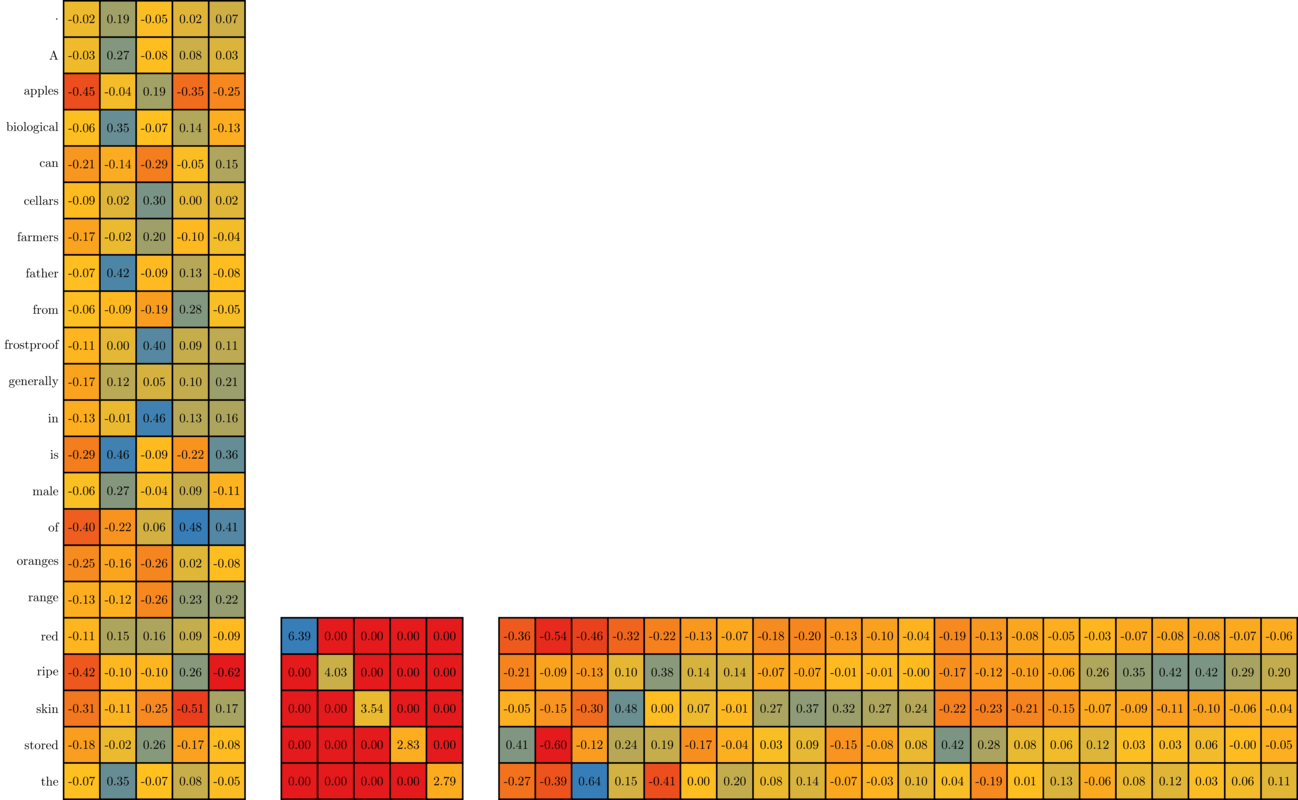

In [5]:
df = to_df(f, id2word)
C = torch.Tensor(df.as_matrix())
U, S, V = C.svd()
S = torch.diag(S)[:5,:5]
tikz(plot_matrix(U[:,:5]) + ticks(yticks=df.index) + shift(plot_matrix(S), 6) + 
     shift(plot_matrix(V[:,:5].transpose(1,0)), 12), height=800)

# CBoW
- Given context words $\ls{C} = [w_{t-2}, w_{t-1}, w_{t+1}, w_{t+2}]$ predict $w_t$
- Example
## skin of ripe ___ is generally red
- Model
$$
P(w_t \ |\ \ls{C}) = \softmax\left(\mat{W}\sum_{w_i\in\ls{C}}\vec{v}_{w_i}\right)_{w_t}
$$
where $\mat{W}\in\R^{|\mathbb{V}|\times k}$
- Loss for a single traniing instance of word and context
$$
\loss(w_t, \ls{C}) =  -\log P(w_t \ |\ \ls{C})
$$

<div class=cite>[Mikolov et al. 2013]</div>

# word2vec
- Given $w_t$ predict context words $\ls{C} = [w_{t-2}, w_{t-1}, w_{t+1}, w_{t+2}]$

- Model
$$
P(\ls{C}\ |\ w_t) = \prod_{w_i\in\ls{C}}\softmax(\mat{W}\vec{v}_{w_t})_{w_i}
$$
- Loss
$$
\loss(w_t, \ls{C}) = -\log P(\ls{C}\ |\ w_t) = -\sum_{w_i\in\ls{C}}\log(\softmax(\mat{W}\vec{v}_{w_t})_{w_i})
$$
<div class=cite>[Mikolov et al. 2013]</div>
- In practise: sample negative contexts; sampled softmax


# Linear Relationships
<img src="./figures/proprietary/word2vec.png" width=80%>

\begin{align}
\Large
\vec{v}_\text{king} - \vec{v}_\text{man} + \vec{v}_\text{woman} &= \Large\vec{v}_\text{queen}\\
\Large
\vec{v}_\text{swimming} + {\color{red}\vec{v}_\text{past}} &= \Large\vec{v}_\text{swam}\\
\Large
\vec{v}_\text{Germany} + {\color{red}\vec{v}_\text{capital}} &= \Large\vec{v}_\text{Berlin}
\end{align}

# Poincaré Embeddings

<img src="./figures/proprietary/nickel2017poincar/geodiscs.png" width=1000>

<div class=cite>[Nickel and Kiela, 2017]</div>

# Poincaré Embeddings


<img src="./figures/proprietary/nickel2017poincar/before.png" width=500> | <img src="./figures/proprietary/nickel2017poincar/after.png" width=500> 
:--:|:--:

<div class=cite>[Nickel and Kiela, 2017]</div>

# Further Reading
- [Bengio et al. A Neural Probabilistic Language Model. 2003.](http://papers.nips.cc/paper/1839-a-neural-probabilistic-language-model.pdf)
- [Goldberg and Levy. word2vec Explained: deriving Mikolov et al.'s negative-sampling word-embedding method. 2014](https://arxiv.org/abs/1402.3722)
- [Nickel and Kiela. Poincaré Embeddings for Learning Hierarchical Representations. 2017.](https://arxiv.org/abs/1705.08039)
- ...
- [Cho. Natural Language Understanding with Distributed Representation. 2015.](https://arxiv.org/abs/1511.07916)
- [Deep Learning for NLP Best Practices](http://ruder.io/deep-learning-nlp-best-practices/)
- [Deep Learning for NLP resources](https://github.com/andrewt3000/DL4NLP)
- [Goldberg. A Primer on Neural Network Models for Natural Language Processing. 2016.](https://www.jair.org/media/4992/live-4992-9623-jair.pdf)
- [Goodfellow et al. Deep Learning. 2017.](http://www.deeplearningbook.org/)
- [Grefenstette et al. New Directions in Vector Space Models of Meaning. 2014.](https://www.cs.ox.ac.uk/files/6605/aclVectorTutorial.pdf)
- [Grefenstette. Beyond Sequence to Sequence with Augmented RNNs. 2016](https://drive.google.com/file/d/0B_wzP_JlVFcKYTFaTVFJN18tbmtkX2V0WEEtWXVSdDV4UHVZ/view)
- [Oxford Deep NLP 2017 course](https://github.com/oxford-cs-deepnlp-2017/lectures)
- [Stanford Deep Learning for Natural Language Processing course](http://cs224d.stanford.edu/syllabus.html)